In [1]:
import os
os.chdir('../..')

In [2]:
import numpy as np
import pandas as pd

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

import matplotlib.pyplot as plt
import matplotlib

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Load the files

In [3]:
files = ['../data/Chicago/full.csv', 
         '../synth_data/Chicago/tgan_100.csv', 
         '../synth_data/Chicago/tgan_1000.csv', 
         '../synth_data/Chicago/ctgan.csv',
         '../synth_data/Chicago/ctgan_300.csv',
         '../synth_data/Chicago/ctgan_1000.csv']
labels = ['original', 'tgan - 100ep', 'tgan - 1000ep', 'ctgan - 100ep', 'ctgan - 300ep', 'ctgan - 1000ep']

In [4]:
dfs = [pd.read_csv(file) for file in files]

# All to numeric

In [5]:
ints = ['travel_dow', 'hh_vehicles', 'hh_size', 'hh_bikes', 'hh_descr', 'hh_income', 'gender', 'education_level', 'age']
floats = ['departure_time', 'distance', 'license']

In [6]:
dct = {}

for i in ints:
    dct[i] = 'int64'
    
for i in floats:
    dct[i] = 'float64'

In [7]:
dct

{'travel_dow': 'int64',
 'hh_vehicles': 'int64',
 'hh_size': 'int64',
 'hh_bikes': 'int64',
 'hh_descr': 'int64',
 'hh_income': 'int64',
 'gender': 'int64',
 'education_level': 'int64',
 'age': 'int64',
 'departure_time': 'float64',
 'distance': 'float64',
 'license': 'float64'}

In [8]:
dfs = [df.astype(dct) for df in dfs]

In [9]:
choices = {}
trip_purpose = {}
work_status = {}

for c in ['choice', 'trip_purpose', 'work_status']: 
    dct = {}
    
    for n, i in enumerate(dfs[0][c].unique()):
        if c == 'choice':
            choices[n] = i
            
        if c == 'trip_purpose':
            trip_purpose[n] = i
            
        if c == 'work_status':
            work_status[n] = i
        
        dct[i] = n
        
    dfs = [df.replace(dct) for df in dfs]

In [10]:
dfs[0].dtypes

choice               int64
travel_dow           int64
trip_purpose         int64
distance           float64
hh_vehicles          int64
hh_size              int64
hh_bikes             int64
hh_descr             int64
hh_income            int64
gender               int64
age                  int64
license            float64
education_level      int64
work_status          int64
departure_time     float64
dtype: object

# Standardized the data

In [11]:
full_df = dfs[0]
for i in range(1, len(dfs)):
    
    full_df = full_df.append(dfs[i], ignore_index=True)

scaler = StandardScaler()
scaler.fit(full_df)

StandardScaler()

In [12]:
stand = []

for df in dfs:
    stand.append(scaler.transform(df))

# PCA

In [17]:
angles = []
mse = []
pca_var = []

orig_pca = decomposition.PCA(n_components=len(dfs[0].columns))
orig_pca.fit(stand[0])
pca_var.append(orig_pca.explained_variance_)

for st in stand[1:]:
    
    synth_pca = decomposition.PCA(n_components=len(dfs[0].columns))
    synth_pca.fit(st)
    
    pca_var.append(synth_pca.explained_variance_)
    
    tmp_angle = []
    tmp_mse = []
    
    for eig_orig, eig_synth in zip(orig_pca.components_, synth_pca.components_):
        dot_product = np.dot(eig_orig, eig_synth)
        angle = np.arccos(dot_product)
        tmp_angle.append(angle)
        
        tmp_mse.append(mean_squared_error(eig_orig, eig_synth))
        
    angles.append(tmp_angle)
    mse.append(tmp_mse)

Weighted average of angles
tgan - 100ep: 0.876
tgan - 1000ep: 1.068
ctgan - 100ep: 1.479
ctgan - 300ep: 1.560
ctgan - 1000ep: 1.341


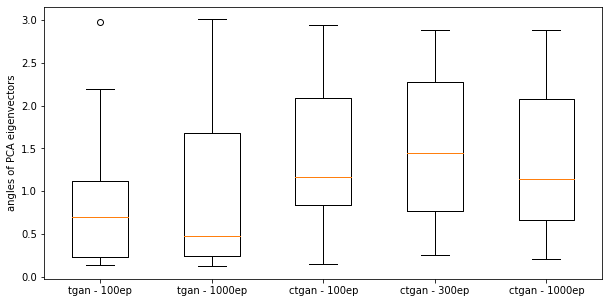

In [32]:
plt.figure(figsize=(10,5))
plt.boxplot(angles)
plt.xticks(range(1,len(angles)+1), labels[1:])
plt.ylabel('angles of PCA eigenvectors')

print("Weighted average of angles")
for i in range(len(angles)):
    print("{}: {:.3f}".format(labels[i+1], np.mean(angles[i])))#*pca_var[0])))

Weighted average of MSE
tgan - 100ep: 0.061
tgan - 1000ep: 0.083
ctgan - 100ep: 0.124
ctgan - 300ep: 0.129
ctgan - 1000ep: 0.109


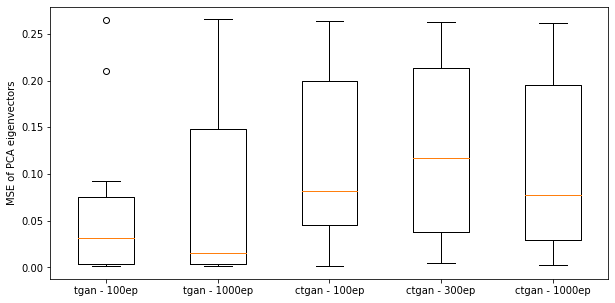

In [31]:
plt.figure(figsize=(10,5))
plt.boxplot(mse)
plt.xticks(range(1,len(mse)+1), labels[1:])
plt.ylabel('MSE of PCA eigenvectors')

print("Weighted average of MSE")
for i in range(len(mse)):
    print("{}: {:.3f}".format(labels[i+1], np.mean(mse[i])))#*(pca_var[0]+pca_var[i+1])/2)))